In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pickle

In [8]:
def save_data(data, filename_no_ext):
    # Uses pickle to save data
    # Filename is given without extension in case method of saving ever changes
    file = open('Output/' + filename_no_ext + '.pickle', 'wb')
    pickle.dump(data, file)
    file.close()
    
def load_data(filename_no_ext):
    # Uses pickle to load data
    file = open('Output/' + filename_no_ext + '.pickle', 'rb')
    data = pickle.load(file)
    file.close()
    return data

In [9]:
# Load train/test split from part 1 of this analysis
X_train, X_test, Y_train, Y_test = load_data('train_test')

In [18]:
# Combine Genotype and Behavior into one grouping variable, ignoring treatment
Y_train_4 = Y_train.Genotype + '_' + Y_train.Behavior
Y_test_4  = Y_test.Genotype  + '_' + Y_test.Behavior

In [40]:
#Load classifiers from part one and re-fit
classifiers = load_data('classifiers_for_voting')
classifier_voting = load_data('classifier_voting')

accuracy = {}
y_pred_df = pd.DataFrame({'Actual': Y_test_4})

for name, classifier in classifiers:
    classifier.fit(X_train, Y_train_4)
    y_pred_df[name] = classifier.predict(X_test)
    accuracy[name] = classifier.score(X_test, Y_test_4)
    
classifier_voting.fit(X_train, Y_train_4)
y_pred_df['Voting'] = classifier_voting.predict(X_test)
accuracy['Voting'] = classifier_voting.score(X_test, Y_test_4)

#Allow manual voting (no weighting)
def combine_results(classifier_list, X_test):
    results = pd.DataFrame()
    for name, classifier in classifier_list:
        y_pred = classifier.predict(X_test)
        results[name] = y_pred
    return results

from collections import Counter
def vote(combined_results):
    y_pred = []
    for idx, row in combined_results.iterrows():
        occurence_count = Counter(row) 
        y_pred.append(occurence_count.most_common(1)[0][0])
    return y_pred

combined_results = combine_results(classifiers, X_test)
y_pred_df['Manual Voting'] = vote(combined_results)
accuracy['Manual Voting'] = np.mean(y_pred_df['Manual Voting'] == Y_test_4)

In [24]:
# Save re-fit classifiers
save_data(classifiers, 'classifiers_for_voting_4GroupFit')
save_data(classifier_voting, 'classifier_voting_4GroupFit')

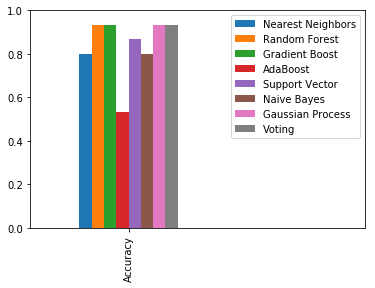

In [39]:
_ = pd.DataFrame(accuracy, index = ['Accuracy']).plot(kind = 'bar')
_ = plt.xlim([-0.5,1.2])
_ = plt.ylim([0,1])

In [41]:
# Compare to 4-group accuracy from previous fitting
def interpret_4_group(class_str):
    class_split = class_str.split('-')
    if (class_split[0] == 'c'):
        genotype = 'Control'
    else:
        genotype = 'Ts65Dn'    
    if (class_split[1] == 'SC'):
        behavior = 'Control'
    else:
        behavior = 'Learning'    
    #if (class_split[2] == 's'):
    #    treatment = 'Saline'
    #else:
    #    treatment = 'Memantine'
    return genotype + '_' + behavior

def predict_and_score(y_pred_8groups):
    y_pred = [interpret_4_group(y) for y in y_pred_8groups]
    score = np.mean(y_pred == Y_test_4)
    return y_pred, score

classifiers_old = load_data('classifiers_for_voting')
classifier_voting_old = load_data('classifier_voting')

accuracy_old = {}
y_pred_df_old = pd.DataFrame({'Actual': Y_test_4})

for name, classifier in classifiers_old:
    y_pred_df_old[name], accuracy_old[name] = predict_and_score(classifier.predict(X_test))
    
y_pred_df_old['Voting'], accuracy_old['Voting'] = predict_and_score(classifier_voting_old.predict(X_test))

combined_results = combine_results(classifiers_old, X_test)
y_pred_df_old['Manual Voting'], accuracy_old['Manual Voting'] = predict_and_score(vote(combined_results))

accuracy_old

{'Nearest Neighbors': 0.6666666666666666,
 'Random Forest': 0.9333333333333333,
 'Gradient Boost': 0.7333333333333333,
 'AdaBoost': 0.5333333333333333,
 'Support Vector': 0.7333333333333333,
 'Naive Bayes': 0.8,
 'Gaussian Process': 0.9333333333333333,
 'Voting': 0.8666666666666667,
 'Manual Voting': 0.8666666666666667}

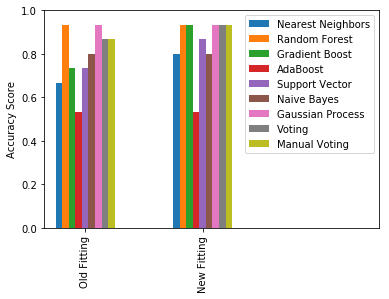

In [53]:
accuracy_df = pd.DataFrame([accuracy_old, accuracy], index = ['Old Fitting', 'New Fitting'], 
             columns = ['Nearest Neighbors', 'Random Forest', 'Gradient Boost', 'AdaBoost',
                        'Support Vector', 'Naive Bayes', 'Gaussian Process', 'Voting', 'Manual Voting'])
_ = accuracy_df.plot(kind = 'bar')
_ = plt.xlim([-0.35,2.5])
_ = plt.ylim([0,1])
_ = plt.ylabel('Accuracy Score')

In [54]:
classifiers[1]

('Random Forest',
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False))

In [59]:
protein_names = load_data('protein_names')
classifier_rf = classifiers[1][1]
importance_df_rf = pd.DataFrame({'protein': protein_names, 
                              'importance': classifier_rf.feature_importances_})
importance_df_rf.to_csv('Output/FeatureImportances_RandomForest_4Group.csv')
importance_df_rf.sort_values('importance', ascending = False).head(10)

,protein,importance
32,SOD1_N,0.061204
30,APP_N,0.057762
1,ITSN1_N,0.055922
0,DYRK1A_N,0.045835
75,CaNA_N,0.044514
10,pERK_N,0.038845
34,P38_N,0.032583
45,pGSK3B_N,0.029779
53,ARC_N_pS6_N,0.027194
20,BRAF_N,0.027098


In [64]:
AOV_results = pd.read_excel('Output/AOV_Results.xls')
AOV_results.rename(columns = {'Unnamed: 0': 'protein'}, inplace = True)
importance_AOV_combine = AOV_results.join(importance_df_rf.set_index('protein'),on = 'protein')
importance_AOV_combine.sort_values('importance', ascending = False).head(10)

,protein,Genotype,Behavior,Treatment,Geno_Behav,Geno_Treat,Behav_Treat,Triple_Interact,importance
32,SOD1_N,7.011768e-01,2.776359e-18,0.340680,0.369252,0.018835,0.321127,0.014473,0.061204
30,APP_N,3.084508e-10,3.163029e-02,0.793155,0.022490,0.881944,0.770758,0.533747,0.057762
1,ITSN1_N,4.702204e-02,2.433821e-06,0.624386,0.621065,0.345508,0.630078,0.496069,0.055922
0,DYRK1A_N,3.045859e-01,2.915787e-06,0.774242,0.857949,0.342902,0.919356,0.265457,0.045835
75,CaNA_N,3.387185e-01,9.359408e-17,0.031853,0.789856,0.463631,0.073963,0.211962,0.044514
10,pERK_N,8.755201e-01,2.029016e-08,0.929771,0.886558,0.445693,0.799756,0.291684,0.038845
34,P38_N,7.047535e-03,9.633999e-13,0.001697,0.075958,0.280272,0.873811,0.313384,0.032583
45,pGSK3B_N,7.472357e-02,5.626939e-08,0.004654,0.015046,0.714000,0.651680,0.079339,0.029779
53,ARC_N_pS6_N,1.722247e-02,1.811754e-13,0.013732,0.156127,0.059355,0.318093,0.000015,0.027194
20,BRAF_N,6.236423e-01,2.686499e-05,0.918740,0.896229,0.253081,0.908995,0.282174,0.027098


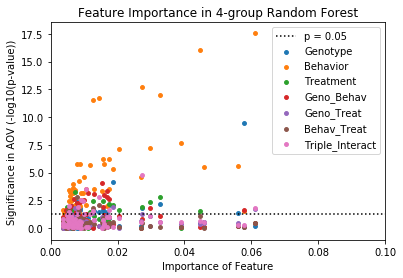

In [144]:
y_columns = importance_AOV_combine.columns[1:8]
for y_col in y_columns:
    _ = plt.scatter(x = importance_AOV_combine.importance, y = -np.log10(importance_AOV_combine[y_col]), s = 15)
_ = plt.xlabel('Importance of Feature')
_ = plt.ylabel('Significance in AOV (-log10(p-value))')
_ = plt.axhline(-np.log10(0.05), linestyle = ':', color = 'k')
_ = plt.xlim([0,0.1]) #Just putting in a little extra room for the legend
_ = plt.legend(['p = 0.05']+list(y_columns))
_ = plt.title('Feature Importance in 4-group Random Forest')

In [125]:
# PCA
# First, combine train and test to recap whole dataset
Y = Y_train.append(Y_test)
X = np.append(X_train, X_test, axis = 0)
Y['Group4'] = Y.Genotype + '_' + Y.Behavior
Y['Group8'] = Y.Group4 + '_' + Y.Treatment #Same as Y['class'] except more descriptive
group_order4 = ('Control_Control', 'Control_Learning', 'Ts65Dn_Control', 'Ts65Dn_Learning')
group_order8 = ('Control_Control_Saline', 'Control_Control_Memantine', 'Control_Learning_Saline', 'Control_Learning_Memantine',
                'Ts65Dn_Control_Saline',  'Ts65Dn_Control_Memantine',  'Ts65Dn_Learning_Saline',  'Ts65Dn_Learning_Memantine')
                
from sklearn.decomposition import PCA
pca = PCA()
prin_comp = pca.fit_transform(X)

In [126]:
colors8 = [(0.6, 0.8, 1.0), (0.3, 0.65, 1.0), #Control genotype, No learning = light blues; opaque = treated
           (0.6, 0.6, 1.0), (0.3, 0.3,  1.0), #Control genotype, Learning = dark blues; opaque = treated
           (1.0, 0.8, 0.6), (1.0, 0.65, 0.3), #Down Syndrome, No Learning = oranges; opaque = treated
           (1.0, 0.6, 0.6), (1.0, 0.3,  0.3)] #Down Syndrome, Learning = reds; opaque = treated
colors4 = colors8[1:8:2]

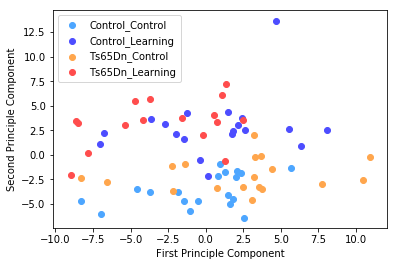

In [145]:
pc_1 = prin_comp[:,0]
pc_2 = prin_comp[:,1]
for idx, group in enumerate(group_order4):
    xi = pc_1[Y.Group4 == group]
    yi = pc_2[Y.Group4 == group]
    _ = plt.scatter(xi, yi, color = colors4[idx])
_ = plt.xlabel('First Principle Component')
_ = plt.ylabel('Second Principle Component')
_ = plt.legend(group_order4)
_ = plt.show()

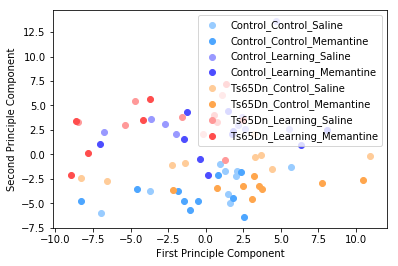

In [146]:
for idx, group in enumerate(group_order8):
    xi = pc_1[Y.Group8 == group]
    yi = pc_2[Y.Group8 == group]
    _ = plt.scatter(xi, yi, color = colors8[idx])
_ = plt.legend(group_order8, )
_ = plt.xlabel('First Principle Component')
_ = plt.ylabel('Second Principle Component')
_ = plt.show()

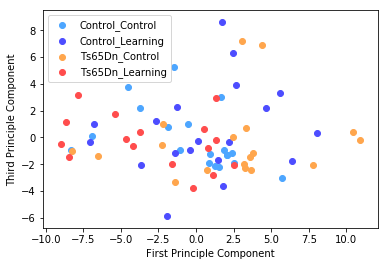

In [148]:
pc_3 = prin_comp[:,2]
for idx, group in enumerate(group_order4):
    xi = pc_1[Y.Group4 == group]
    yi = pc_3[Y.Group4 == group]
    _ = plt.scatter(xi, yi, color = colors4[idx])
_ = plt.xlabel('First Principle Component')
_ = plt.ylabel('Third Principle Component')
_ = plt.legend(group_order4)
_ = plt.show()

In [138]:
from scipy.stats import rankdata
importance_AOV_combine['ImportanceRank'] = 77 - rankdata(importance_AOV_combine.importance)

In [139]:
importance_AOV_combine.sort_values('Genotype', ascending = True).head(20)

,protein,Genotype,Behavior,Treatment,Geno_Behav,Geno_Treat,Behav_Treat,Triple_Interact,importance,ImportanceRank
30,APP_N,3.084508e-10,3.163029e-02,0.793155,0.022490,0.881944,0.770758,0.533747,0.057762,2.0
48,S6_N,7.325182e-05,4.699783e-06,0.008405,0.444576,0.013582,0.310024,0.818501,0.018734,12.0
15,pNR2A_N,4.309082e-03,1.621021e-06,0.091494,0.869894,0.871847,0.001720,0.400161,0.007901,40.0
34,P38_N,7.047535e-03,9.633999e-13,0.001697,0.075958,0.280272,0.873811,0.313384,0.032583,7.0
33,MTOR_N,8.225228e-03,2.838084e-04,0.291156,0.002322,0.516858,0.369796,0.111574,0.017574,13.0
58,GluR3_N,1.102246e-02,8.288547e-01,0.173320,0.830715,0.301729,0.496992,0.391031,0.006340,54.0
46,pPKCG_N,1.161301e-02,7.915156e-01,0.069037,0.351646,0.035812,0.738653,0.013231,0.008274,37.0
14,pNR1_N,1.280644e-02,2.832038e-01,0.935898,0.010545,0.057214,0.659123,0.078247,0.005988,56.0
56,Tau_N,1.423340e-02,5.920250e-02,0.165027,0.319458,0.370372,0.276420,0.476188,0.008843,33.0
53,ARC_N_pS6_N,1.722247e-02,1.811754e-13,0.013732,0.156127,0.059355,0.318093,0.000015,0.027194,9.0


In [140]:
importance_AOV_combine.sort_values('Geno_Behav', ascending = True).head(20)

,protein,Genotype,Behavior,Treatment,Geno_Behav,Geno_Treat,Behav_Treat,Triple_Interact,importance,ImportanceRank
39,pNUMB_N,6.955461e-01,4.459863e-04,0.506109,0.000093,0.106602,0.296936,0.950578,0.015493,20.0
40,RAPTOR_N,3.070763e-01,1.065351e-02,0.166440,0.000490,0.744319,0.455431,0.797829,0.016746,16.0
41,TIAM1_N,1.345481e-01,2.553981e-01,0.908689,0.000654,0.820715,0.323144,0.749466,0.011249,25.0
38,NR2B_N,2.877697e-02,2.947160e-04,0.082955,0.000812,0.181322,0.453416,0.186226,0.013099,22.0
37,AMPKA_N,4.101820e-02,4.756755e-01,0.670274,0.001096,0.609798,0.589713,0.495915,0.015909,18.0
4,NR2A_N,3.543786e-02,1.598546e-01,0.875950,0.001493,0.073292,0.854869,0.098267,0.016847,15.0
2,BDNF_N,6.183844e-01,9.963055e-02,0.429408,0.002321,0.389302,0.327711,0.813493,0.006943,46.0
33,MTOR_N,8.225228e-03,2.838084e-04,0.291156,0.002322,0.516858,0.369796,0.111574,0.017574,13.0
24,ERK_N,2.917891e-01,2.329537e-05,0.050510,0.002670,0.877026,0.912395,0.050654,0.009875,28.0
12,PKCA_N,9.191290e-01,1.127598e-02,0.718588,0.004870,0.763514,0.874142,0.440094,0.008654,35.0


In [142]:
importance_AOV_combine.sort_values('importance', ascending = False).to_csv('Output/RF_4Group_Importance.csv')

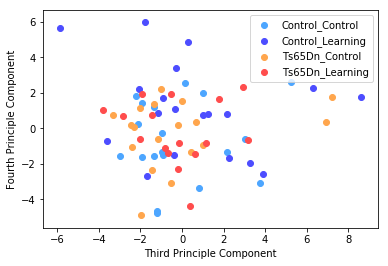

In [150]:
pc_4 = prin_comp[:,4]
for idx, group in enumerate(group_order4):
    xi = pc_3[Y.Group4 == group]
    yi = pc_4[Y.Group4 == group]
    _ = plt.scatter(xi, yi, color = colors4[idx])
_ = plt.xlabel('Third Principle Component')
_ = plt.ylabel('Fourth Principle Component')
_ = plt.legend(group_order4)
_ = plt.show()